<a href="https://colab.research.google.com/github/bhgtankita/ML-DNN/blob/master/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![UNet](https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/raw/53b5e697d3c010546b9443534a067541c4c50eb9/images/u-net-architecture.png)

In [0]:
import sys
import os
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

#seeding
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## If you set the np.random.seed(a_fixed_number) every time you call the numpy's other random function, the result will be the same:

In [0]:
class DataGen(keras.utils.Sequence):
  def __init__(self, ids, path, batch_size=8, image_size=128):
    self.ids = ids
    self.path = path
    self.batch_size = batch_size
    self.image_size = image_size
    self.on_epoch_end()
    
  def __load__(self, id_name):
    #paths
    image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
    mask_path = os.path.join(self.path, id_name, "masks/")
    all_masks = os.listdir(mask_path)
    
    # reading images
    image = cv2.imread(image_path, 1)
    image = cv2.resize(image, (self.image_size, self.image_size))
    
    mask = np.zeros((self.image_size, self.image_size, 1))
    
    #reading masks
    for name in all_masks:
      _mask_path = mask_path + name
      _mask_image = cv2.imread(_mask_path, -1)
      _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size))
      _mask_image = np.expand_dims(_mask_image, axis=-1)
      mask = np.maximum(mask, _mask_image)
      
    #normalizing
    image = image/255.0
    mask = mask/255.0
    
    return image, mask
  
  def __getitem__(self, index):
    if (index+1)*self.batch_size > len(self.ids):
      self.batch_size = len(self.ids) - index*self.batch_size
      
    files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
    
    image = []
    mask = []
    
    for id_name in files_batch:
      _img, _mask = self.__load__(id_name)
      image.append(_img)
      mask.append(_mask)
      
    image = np.array(image)
    mask = np.array(mask)
    
    return image, mask
  
  def on_epoch_end(self):
    pass
  
  def __len__(self):
    return int(np.ceil(len(self.ids)/float(self.batch_size)))
    

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle/8089/all.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1561484720&Signature=W1eSFEOTC38yAzUfyRVALDe%2B8QDcWhS5qe3zzo257J6s31KltwD78vm06XghMxR7jkG1uQ%2FrR4AfeBTgU855boRNxLXP1aTspuBEuwcu88IUiKozPpWTIosXvfhSFKuPZICqFVD7DnUCzXCe8fGThOc8%2FAjY9afK9Ii1RZY6Mp7ZqDCwvLsxvkIhuNRRrJWVxYF5Ik3EAXu6quloUYAOM1QFgucdMVeiRZ1xp439g80axMC5VefBNCJD7fZ0gMgYMYKpQ8fA%2BEelgcrXUfkIbNYfyUeYItDj1WkM%2F8b8jnT9kUAE9fhRdNc4Jeb5k2U2DG1vZbL5FcKZ7zNhkq4Deg%3D%3D&response-content-disposition=attachment%3B+filename%3Ddata-science-bowl-2018.zip" -O "data-science-bowl-2018.zip" -c

--2019-06-22 17:59:14--  https://storage.googleapis.com/kaggle-competitions-data/kaggle/8089/all.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1561484720&Signature=W1eSFEOTC38yAzUfyRVALDe%2B8QDcWhS5qe3zzo257J6s31KltwD78vm06XghMxR7jkG1uQ%2FrR4AfeBTgU855boRNxLXP1aTspuBEuwcu88IUiKozPpWTIosXvfhSFKuPZICqFVD7DnUCzXCe8fGThOc8%2FAjY9afK9Ii1RZY6Mp7ZqDCwvLsxvkIhuNRRrJWVxYF5Ik3EAXu6quloUYAOM1QFgucdMVeiRZ1xp439g80axMC5VefBNCJD7fZ0gMgYMYKpQ8fA%2BEelgcrXUfkIbNYfyUeYItDj1WkM%2F8b8jnT9kUAE9fhRdNc4Jeb5k2U2DG1vZbL5FcKZ7zNhkq4Deg%3D%3D&response-content-disposition=attachment%3B+filename%3Ddata-science-bowl-2018.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c16::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375794049 (358M) [application/zip]
Saving to: ‘data-science-bowl-2018.zip’

data-science-bowl-2 100%[==============

In [9]:
!unzip data-science-bowl-2018.zip

Archive:  data-science-bowl-2018.zip
  inflating: stage2_test_final.zip   
  inflating: stage1_solution.csv     
  inflating: stage1_sample_submission.csv  
  inflating: stage1_test.zip         
  inflating: stage2_sample_submission_final.csv  
  inflating: stage1_train_labels.csv  
  inflating: stage1_train.zip        


In [12]:
!ls

data-science-bowl-2018.zip    stage1_train_labels.csv
gdrive			      stage1_train.zip
stage1_sample_submission.csv  stage2_sample_submission_final.csv
stage1_solution.csv	      stage2_test_final.zip
stage1_test.zip


In [0]:
!mkdir dataset

In [14]:
cd dataset

/content/dataset


In [0]:
!mkdir stage1_train

In [16]:
cd ..

/content


In [0]:
!unzip stage1_train.zip -d /content/dataset/stage1_train

In [26]:
!ls 'dataset/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552'

images	masks


# Hyperparameters

In [0]:
image_size = 128
train_path = "dataset/stage1_train/"
epochs = 5
batch_size = 8

#Traning Ids
train_ids = next(os.walk(train_path))[1]

#Validation data size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [28]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


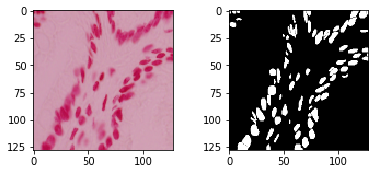

In [34]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

# Network Architecture

In [0]:
def down_block(x, filters, kernel_size=(3,3), padding="same", strides=1):
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
  p = keras.layers.MaxPool2D((2,2), (2,2))(c)
  return c, p

def up_block(x, skip, filters, kernel_size=(3,3), padding="same", strides=1):
  us = keras.layers.UpSampling2D((2,2))(x)
  concat = keras.layers.Concatenate()([us, skip])  
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
  return c

def bottleneck(x, filters, kernel_size=(3,3), padding="same", strides=1):
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
  return c

# UNET Model

In [0]:
def UNet():
  f = [16, 32, 64, 128, 256]
  inputs = keras.layers.Input((image_size, image_size, 3))
  
  p0 = inputs
  c1, p1 = down_block(p0, f[0]) #128 -> 64
  c2, p2 = down_block(p1, f[1]) #64 -> 32
  c3, p3 = down_block(p2, f[2]) #32 -> 16
  c4, p4 = down_block(p3, f[3]) #16->8
    
  bn = bottleneck(p4, f[4])
    
  u1 = up_block(bn, c4, f[3]) #8 -> 16
  u2 = up_block(u1, c3, f[2]) #16 -> 32
  u3 = up_block(u2, c2, f[1]) #32 -> 64
  u4 = up_block(u3, c1, f[0]) #64 -> 128
    
  outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
  model = keras.models.Model(inputs, outputs)
  return model  

In [38]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

W0622 18:55:14.524138 140229891192704 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0622 18:55:15.070938 140229891192704 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# Training

In [39]:
train_gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
valid_gen = DataGen(valid_ids, train_path, batch_size=batch_size, image_size=image_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/5
82/82 [==============================] - 25s 309ms/step - loss: 0.4109 - acc: 0.8465 - val_loss: 0.2953 - val_acc: 0.8006
Epoch 2/5
82/82 [==============================] - 14s 170ms/step - loss: 0.2089 - acc: 0.8870 - val_loss: 0.1003 - val_acc: 0.9637
Epoch 3/5
82/82 [==============================] - 13s 160ms/step - loss: 0.1333 - acc: 0.9327 - val_loss: 0.0539 - val_acc: 0.9689
Epoch 4/5
82/82 [==============================] - 13s 161ms/step - loss: 0.1131 - acc: 0.9404 - val_loss: 0.0510 - val_acc: 0.9699
Epoch 5/5
82/82 [==============================] - 13s 164ms/step - loss: 0.1129 - acc: 0.9409 - val_loss: 0.0421 - val_acc: 0.9725


#Testing

In [0]:
model.save_weights("UNet_weights.h5")

#Prediction
x,y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

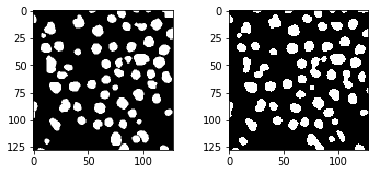

In [46]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

Reference: https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb

Video: https://www.youtube.com/watch?v=M3EZS__Z_XE&t=1089s

Dataset: https://www.kaggle.com/c/data-science-bowl-2018